# Goal - In this notebook, I will set up the data for machine learning. 

This includes: 

1. Loading the hdf with the data.
2. Select the urls with only one category. 
3. Identifying the urls that have are represented in the directory on AWS an selecting for those.  
4. Loading the sql database. 
5. Matching the two together.
6. Counting the number of categories. 
7. Deciding on a decent cut off for categories to include. 
8. Splitting the Data into Test and Train. (we should actually do by category maybe. 


### First load modules. 


In [119]:
%matplotlib inline
%config InlineBackend.figure_format='retina'   
from os.path import join
from pandas import DataFrame
from os import getcwd, listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

#append the path for my own funtions and import them 
import sys
sys.path.append('/home/ubuntu/InsightProject')
from scraper import * 
from data_functions import *

In [162]:
### Get the data
path ='/home/ubuntu/data'
data = pd.read_hdf(join(path,'GoGuardianClassified_Unique-9-19-2015.hdf' ),'goguardian')

In [310]:
print 'The length of the data is %d' %len(data)
data.head()

The length of the data is 2471874


,id,url,catIDs,catNames,parentIDs,parentNames,number_categories,number_parents,visited,saved,size
0,3,0--ass-cinema-newsp.da.ru,[2],[Pornography],[0.0],[nan],1,1,True,True,9205
1,5,0--fightingshaving.da.ru,[2],[Pornography],[0.0],[nan],1,1,True,True,9205
2,6,0--foodwarez.da.ru,[2],[Pornography],[0.0],[nan],1,1,True,True,9205
3,7,0--gratis.dk,[2],[Pornography],[0.0],[nan],1,1,True,False,0
4,12,0-0-0-1blowjob.da.ru,[2],[Pornography],[0.0],[nan],1,1,True,True,9205


### Select urls with only one category. 

In [311]:
data_one = data.query('number_categories ==1')

In [312]:
data_one.shape

(2330668, 11)

### Select urls that that have data present in the sql database. 

1. Import the needed sql alchemy function.
2. Read the sql into a data frame. 
3. Append the file name column. 
4. Query the data_one for entries in the urls data frame. 

In [166]:
from sqlalchemy import create_engine

In [167]:
eng = create_engine('mysql://root:@localhost/url')

#### Read in the classifier_htmls table and do some calculataions

In [31]:
urls = pd.read_sql('select * from classifier_htmls',con =eng)

In [87]:
urls.head()

,urlID,url,htmlsText,htmlsSize
0,1,harjot_com.txt,You don t have permission to access on this ...,184
1,2,christchurch_www2_onlink_net.txt,,5
2,3,teenpages_net.txt,,6
3,4,kamimarket_pl.txt,Blokada administracyjna Jeli jeste abonentem ...,231
4,5,free_os_pl.txt,,13


In [89]:
urls = urls.copy()
urls['Word_Number'] = urls.htmlsText.apply( lambda x: len(x.split()))

In [93]:
urls.Word_Number.describe()

count     52499.000000
mean        452.778491
std        2227.518713
min           0.000000
25%          14.000000
50%         134.000000
75%         441.000000
max      148335.000000
Name: Word_Number, dtype: float64

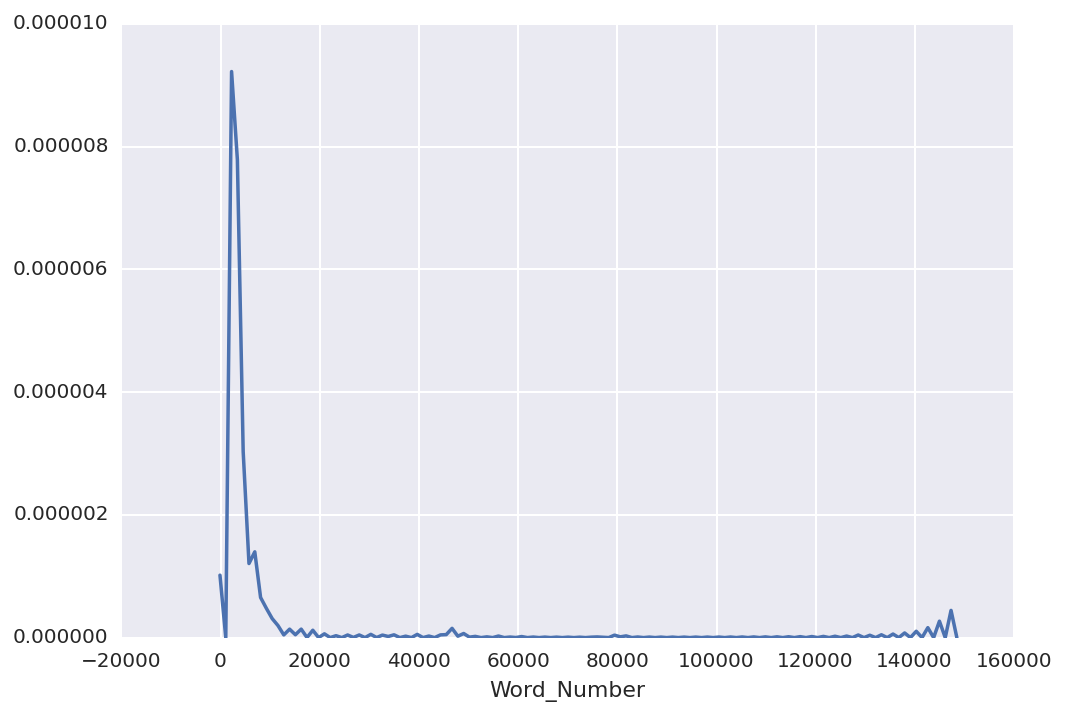

In [121]:
sns.distplot(urls.Word_Number, hist= False)

#### Decisions: 
The issue is that many of the htmls actually have very few word. I think I need more data density than ten words. What is the cumulative distributions? 

Below, I determine the cumulative distributions and plot the cumulative distributions. 

In [174]:
l = len(urls.Word_Number)*1.0
X = np.linspace(0,l,1000)
cumulative = np.array([np.sum(urls.Word_Number>x)/l for x in X])

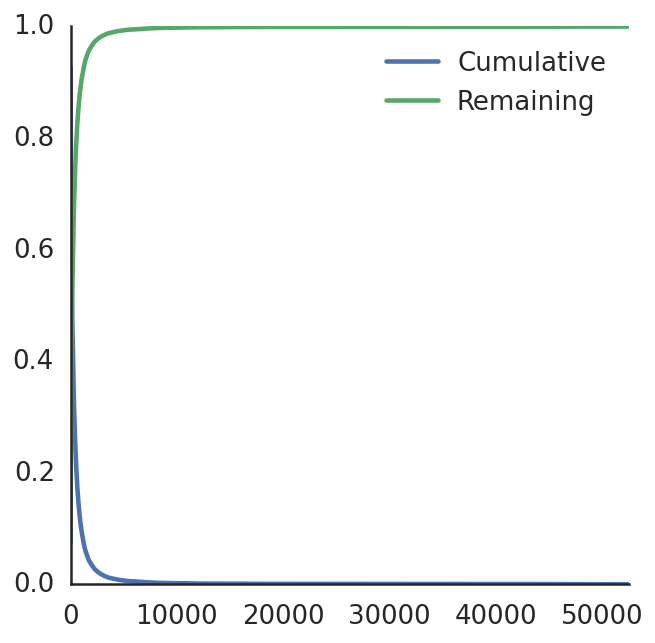

In [308]:
%matplotlib inline
remaining = 1-cumulative
cum = pd.DataFrame({'Cumulative':cumulative, 'Remaining':remaining})

ax=cum.plot(x=X,figsize=(5,5))
sns.despine()

(0, 25)

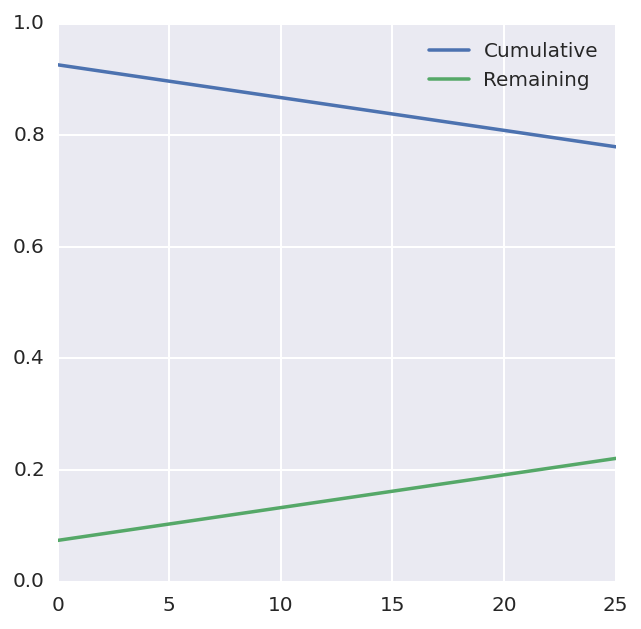

In [262]:
ax=cum.plot(x=X,figsize=(5,5))
ax.set_xlim(0,25)

#### subset the urls to include only urls that have greater than or equal to  5 words (this is arbitrary). 
I chose this based on discussion withs with Lavanya and Abram. They were super helpful. 

Below I get urls that have at least 5 words. 

In [265]:
urls_sub = urls.query('Word_Number >=5')

urls_sub.shape

(44193, 5)

### Query the data_one for entries in the urls data frame.

Below I do the following.

1. I 'calculate' the file name for each html within the urls. 
2. I query for urls that are acutally in the url list. This have greater than 5 words. 

In [313]:
data_one  =data_one.copy()
data_one['file_name'] = data_one.url.apply(lambda x: '.'.join([rename_url(x),'txt']))

In [316]:
htmls = urls_sub.url
data_two = data_one.query('file_name in @htmls')
print 'The number of entries in data_two is %d' %len(data_two)

The number of entries in data_two is 41074


In [317]:
data_two.head()

,id,url,catIDs,catNames,parentIDs,parentNames,number_categories,number_parents,visited,saved,size,file_name
0,3,0--ass-cinema-newsp.da.ru,[2],[Pornography],[0.0],[nan],1,1,True,True,9205,0--ass-cinema-newsp_da_ru.txt
1,5,0--fightingshaving.da.ru,[2],[Pornography],[0.0],[nan],1,1,True,True,9205,0--fightingshaving_da_ru.txt
2,6,0--foodwarez.da.ru,[2],[Pornography],[0.0],[nan],1,1,True,True,9205,0--foodwarez_da_ru.txt
4,12,0-0-0-1blowjob.da.ru,[2],[Pornography],[0.0],[nan],1,1,True,True,9205,0-0-0-1blowjob_da_ru.txt
5,15,0-0-0.com,[2],[Pornography],[0.0],[nan],1,1,True,True,14136,0-0-0_com.txt


Note that there are fewer htmls than expected because I downloaded some of them prior to realizing that some of them were multiple category. I selected one that only had one category. 

### Clean up the data frame. 

1. Convert the catIDs, CatNames, ParentIDs, ParentNames to a single value. 
2. Remove some of the columns. 

In [327]:
data_final = data_two.copy()

In [328]:
data_final.catIDs = data_final.catIDs.apply(lambda x: x[0])

In [329]:
data_final.catNames = data_final.catNames.apply(lambda x:x[0])

In [330]:
data_final.parentIDs = data_final.parentIDs.apply(lambda x: x[0])

In [331]:
data_final.parentNames = data_final.parentNames.apply(lambda x: x[0])

In [332]:
data_final = data_final.iloc[:, :6]

In [333]:
data_final.head()

,id,url,catIDs,catNames,parentIDs,parentNames
0,3,0--ass-cinema-newsp.da.ru,2,Pornography,0,NaN
1,5,0--fightingshaving.da.ru,2,Pornography,0,NaN
2,6,0--foodwarez.da.ru,2,Pornography,0,NaN
4,12,0-0-0-1blowjob.da.ru,2,Pornography,0,NaN
5,15,0-0-0.com,2,Pornography,0,NaN


### Plot the number of categories to determine the distributions of the categories. 

Below I plot the number of documents that are > 5 words within a document. I also plot the parent categories.

In [334]:
categories = count_columns(data_final, 'catNames')

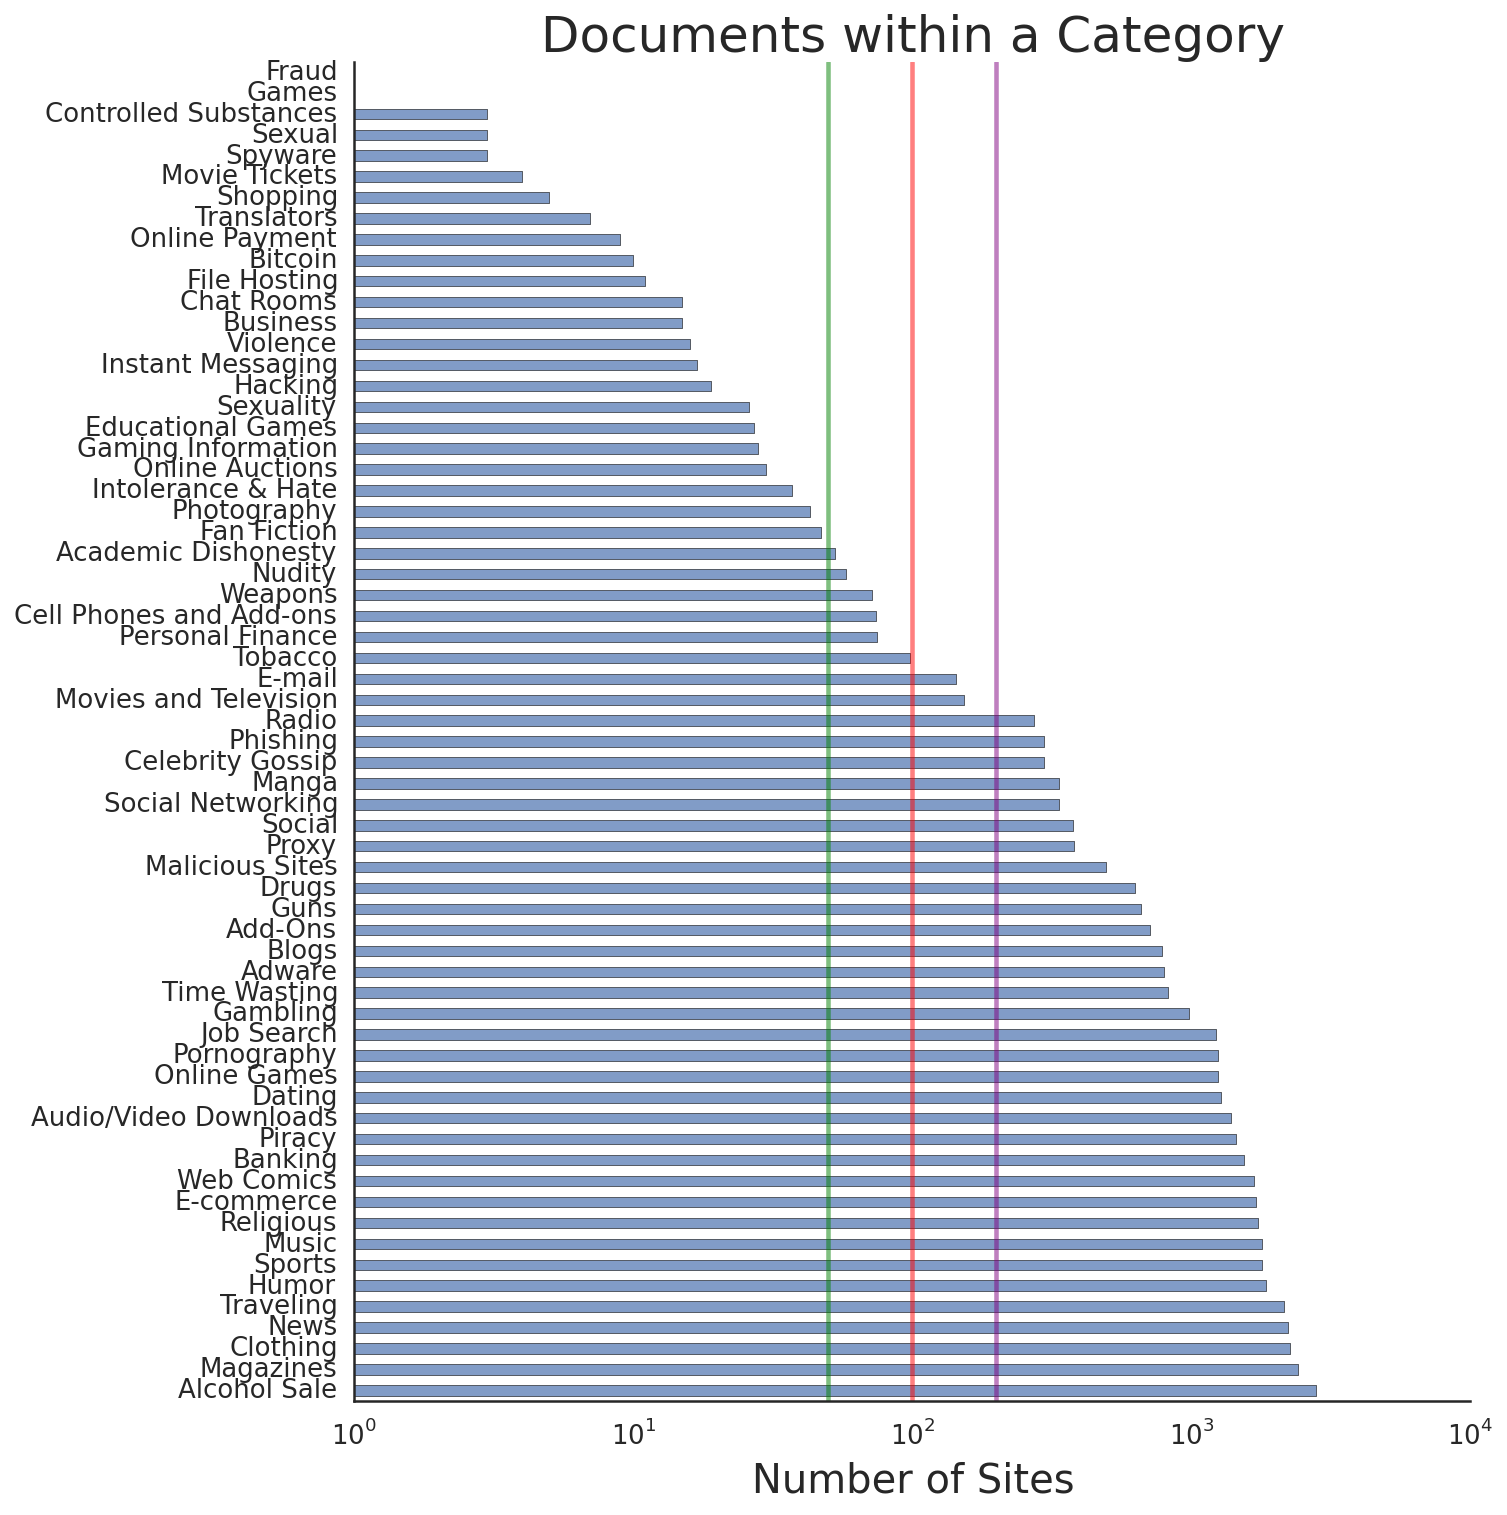

In [335]:
sns.set_context('talk')
sns.set_style('white')
categories.Counts.plot('barh', figsize =(10,12), alpha =0.7, logx = True,edgecolor=None)
plt.axvline(50, c='green',alpha = 0.5)
plt.axvline(100, c='red',alpha = 0.5)
plt.axvline(200,c='purple',alpha = 0.5)
plt.xlabel('Number of Sites',size = 20)
plt.title('Documents within a Category', size = 25)
sns.despine()

#### Lets look at the parent sites
Below I: 

1. Map the parent names as required. (Basically I am aggregating the parents).

In [336]:
cats = data_final[['catNames', 'parentNames']].copy()
cats.drop_duplicates(inplace=True)

In [337]:
cats.head()

,catNames,parentNames
0,Pornography,NaN
49114,Chat Rooms,Social
189761,Movies and Television,Entertainment
230599,Weapons,Aggressive Behavior
230636,Guns,Aggressive Behavior


In [338]:
cats.parentNames=cats.parentNames.astype(str)

In [339]:
rows = [row[1] for row in cats.iterrows()]
cat_map ={}
for row in rows:
    if row[1] =='nan':
        cat_map[row[0]]=row[0] 
    else: 
        cat_map[row[0]]= row[1]

In [340]:
data_final['parentMapped']= data_final.catNames.map(cat_map)

In [341]:
parents = count_columns(data_final, 'parentMapped')

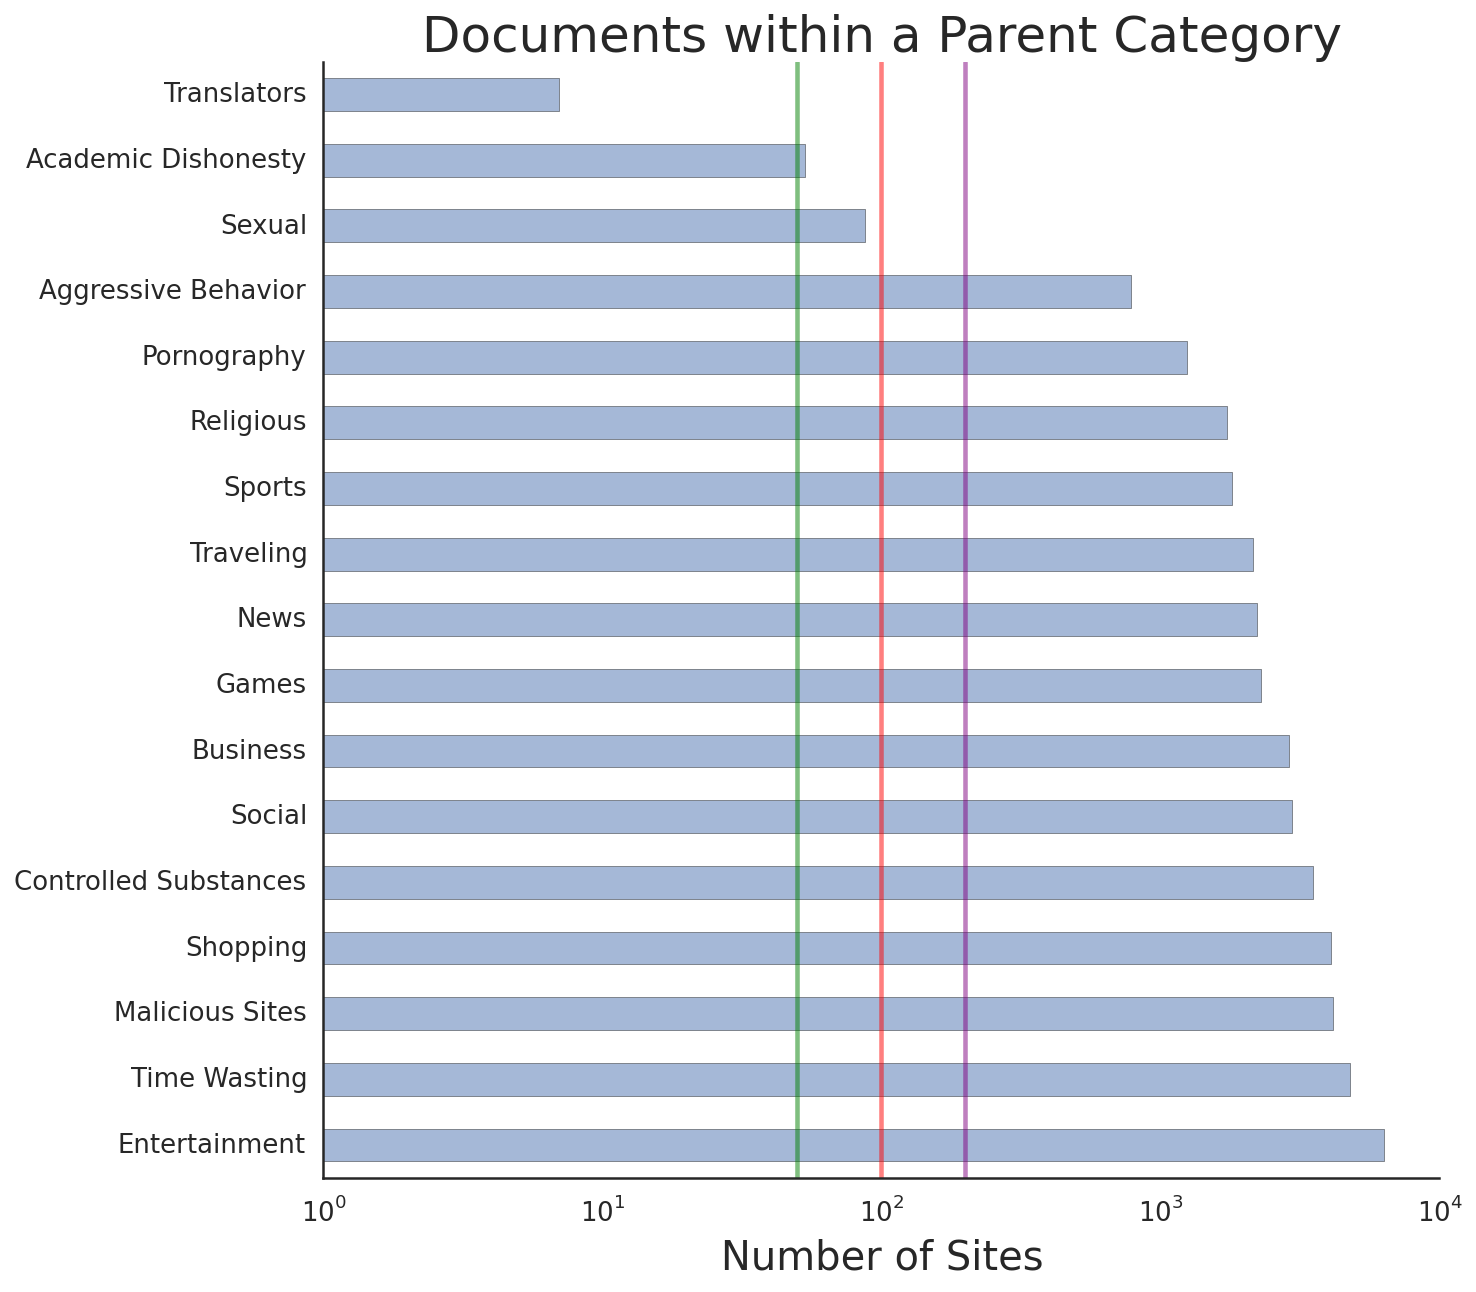

In [342]:
sns.set_context('talk')
sns.set_style('white')
parents.Counts.plot('barh', figsize =(10,10), alpha =0.5, logx=True,edgecolor=None)
plt.axvline(50, c='green',alpha = 0.5)
plt.axvline(100, c='red',alpha = 0.5)
plt.axvline(200,c='purple',alpha = 0.5)
plt.xlabel('Number of Sites',size = 20)
plt.title('Documents within a Parent Category', size = 25)
sns.despine()

In [343]:
parents

,Category,Counts
Entertainment,Entertainment,6322
Time Wasting,Time Wasting,4792
Malicious Sites,Malicious Sites,4165
Shopping,Shopping,4075
Controlled Substances,Controlled Substances,3527
Social,Social,2950
Business,Business,2880
Games,Games,2290
News,News,2215
Traveling,Traveling,2143


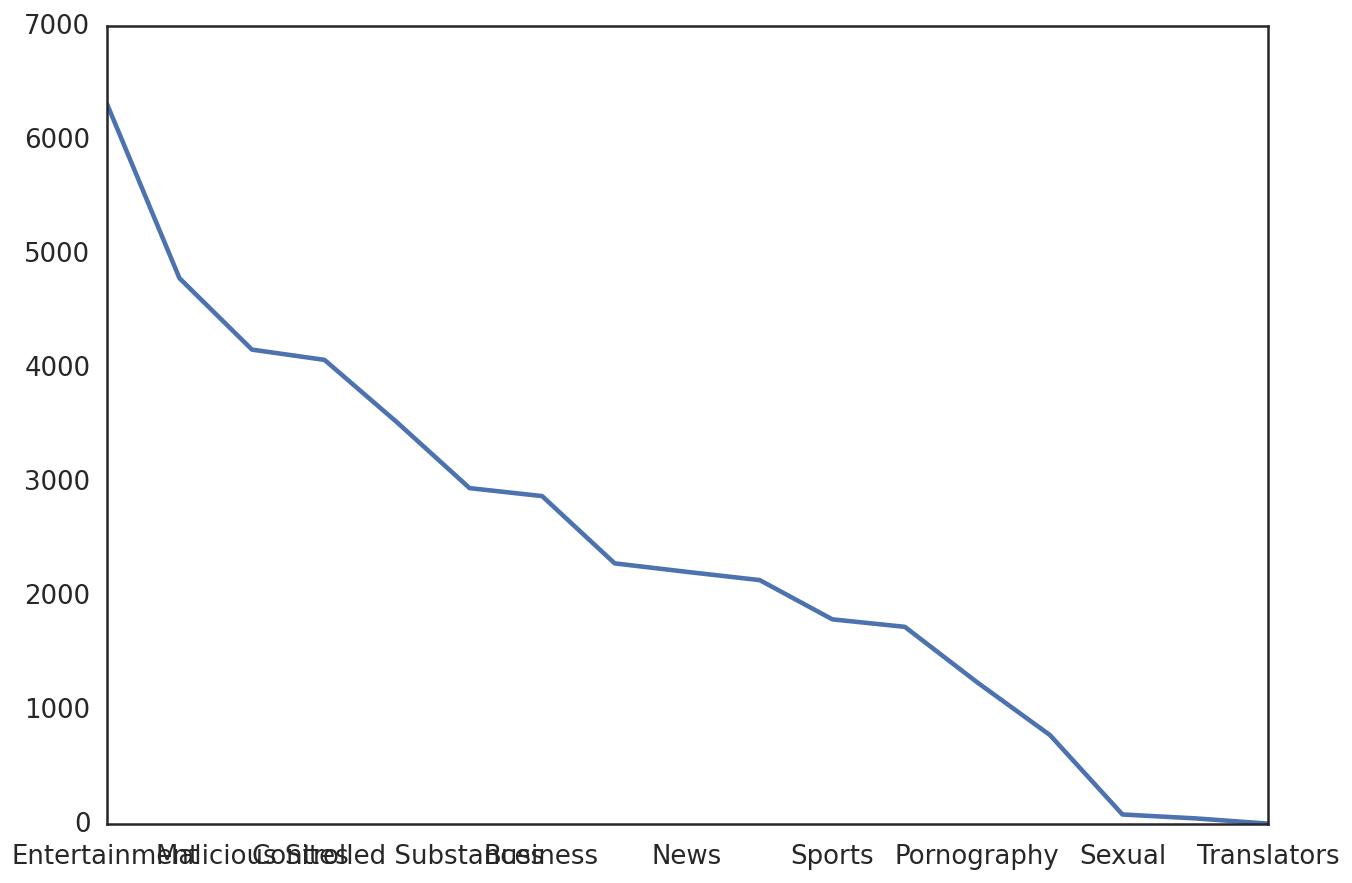

In [358]:
parents.Counts.plot()

In [345]:
print 'There are %d parent categories' %len(parents)

There are 17 parent categories


### Decisions. 
Based on this I have decide to descope and go for a slighly less ambitious classification scheme. I will focus in the websites based on the Parent Categoy. I will allow for all websites except the translators.  

### Select the final data set prior to selection. 

To do this: 

1. Select sites that do not belong in Translators. 
2. Shuffle the data frame. 
3. Pick at up to  2000 sites from each using a group by 
4. Save this as the data set. 

In [360]:
translators = ['Translators']
data_final_parent = data_final.query('parentMapped not in @translators')

In [361]:
data_final_parent.shape

(41067, 7)

In [362]:
data_final_parent = shuffle_dataframe( data_final_parent)

In [363]:
data_final_parent.head()

,id,url,catIDs,catNames,parentIDs,parentNames,parentMapped
266126,678292,gesichterparty.de,19,Social,0,NaN,Social
1073540,3137041,netbet.com,3,Online Games,13,Games,Games
2215739,5297106,bishopbyrne.org,65,Religious,0,NaN,Religious
249713,652814,gamespydaily.com,10,Time Wasting,0,NaN,Time Wasting
1905310,4984351,bancorpsouth.com,48,Banking,47,Business,Business


In [364]:
n = 2000
data_final_parent_sub = data_final_parent.groupby('parentMapped').apply(select_n,n)

In [365]:
data_final_parent_sub.shape

(25701, 7)

### Plot the distribution of remaining sites

Here I plot the above

In [374]:
parents_sub_count = count_columns(data_final_parent_sub, 'parentMapped')

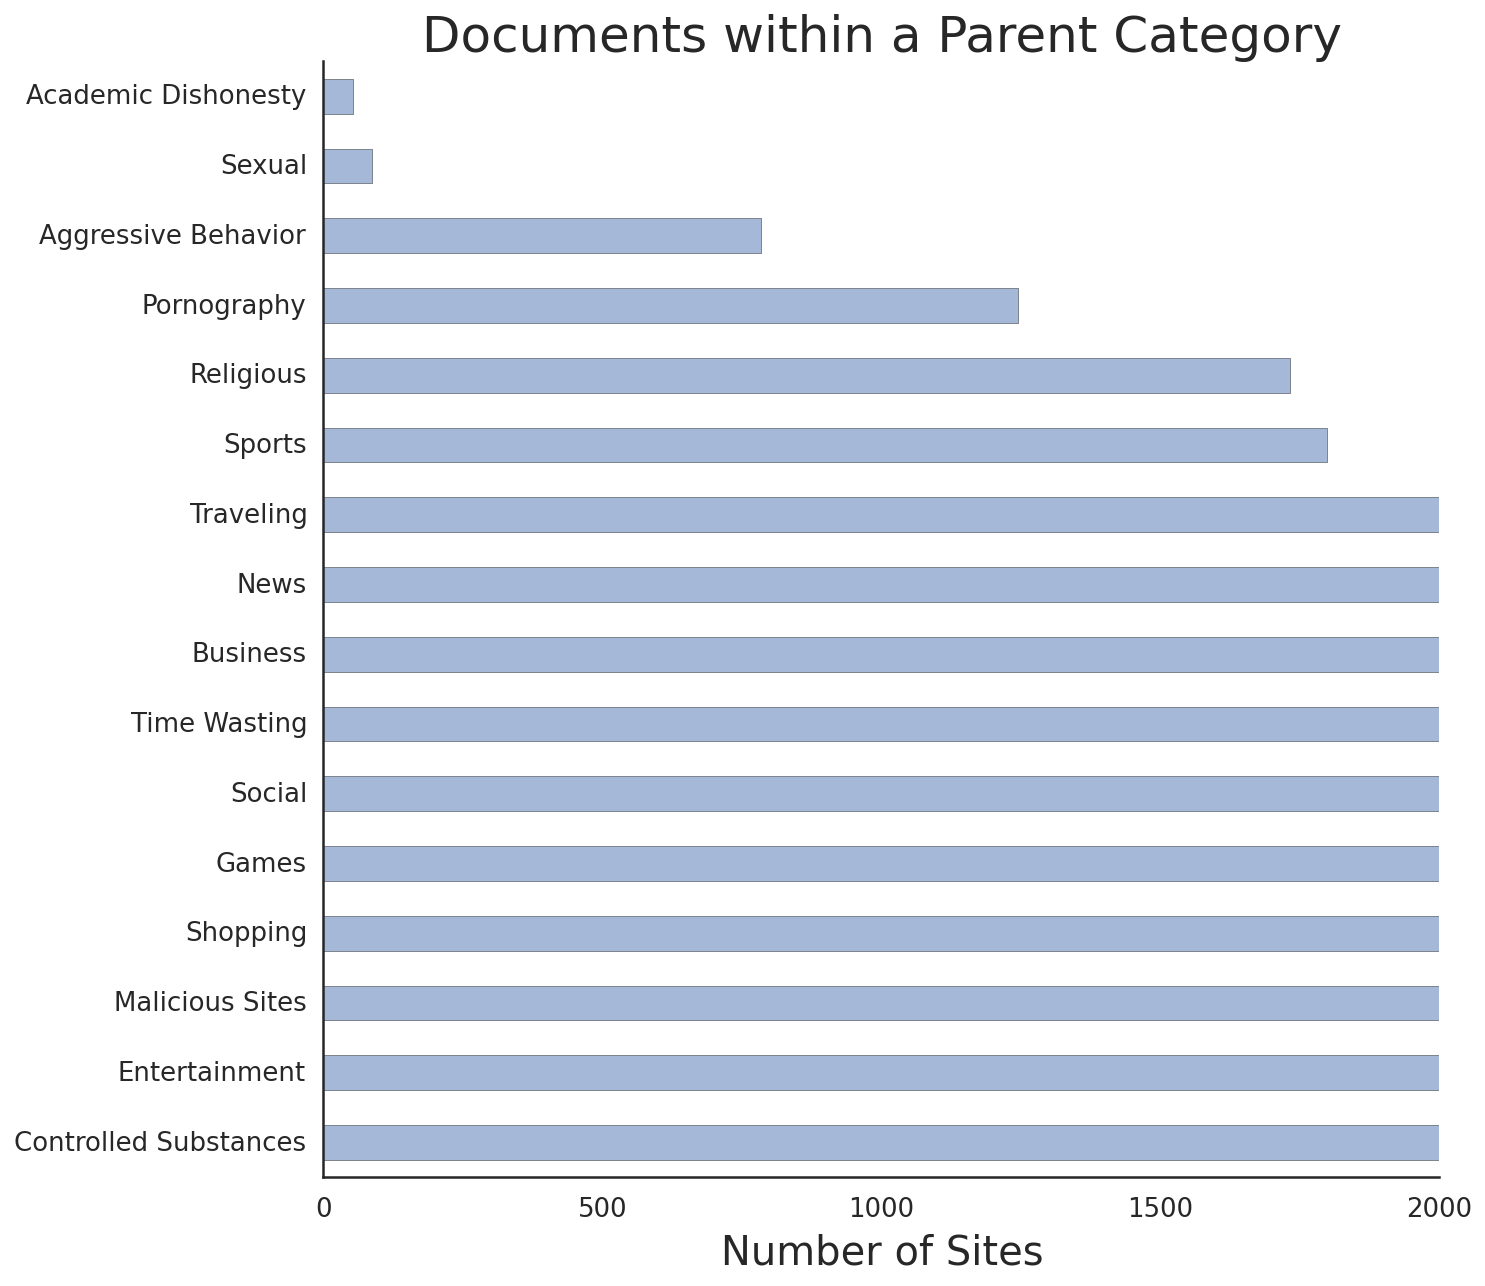

In [375]:
sns.set_context('talk')
sns.set_style('white')
parents_sub_count.Counts.plot('barh', figsize =(10,10), alpha =0.5,edgecolor=None)
plt.xlabel('Number of Sites',size = 20)
plt.title('Documents within a Parent Category', size = 25)
sns.despine()

In [419]:
parents_sub_count

,Category,Counts
Controlled Substances,Controlled Substances,2000
Entertainment,Entertainment,2000
Malicious Sites,Malicious Sites,2000
Shopping,Shopping,2000
Games,Games,2000
Social,Social,2000
Time Wasting,Time Wasting,2000
Business,Business,2000
News,News,2000
Traveling,Traveling,2000


### Remarks: 

Above is is my final data set that I will use to train the model. It is pretty good. Not to unbalanced. One question- what is the average number of words per category type. This is something we can answer next week. 

## Set up a test and train set that I will be using to train a series of models. 

1. First query the urls to have the same url as the parent_subset.
2. Merge the Data. 
3. Save the merged Data
3. Extract the categories and the text and assign them as X and Y respectively. 
4. Save as X and y to data sets. 
5. Split the data to train and test.
6. Save these as own data set. 

### First query the urls to have the same url as the parent_subset.

In [384]:
urls.head()

,urlID,url,htmlsText,htmlsSize,Word_Number
0,1,harjot_com.txt,You don t have permission to access on this ...,184,29
1,2,christchurch_www2_onlink_net.txt,,5,0
2,3,teenpages_net.txt,,6,0
3,4,kamimarket_pl.txt,Blokada administracyjna Jeli jeste abonentem ...,231,31
4,5,free_os_pl.txt,,13,0


In [389]:
# make a copy of the data. 
data =data_final_parent_sub.copy()

In [390]:
#append 'file_name
data['file_name'] = data.url.apply(lambda x: '.'.join([rename_url(x),'txt']))

In [393]:
#subset urls
urls = urls.query('url in @data.file_name')

In [408]:
#rename url to file_name
urls = urls.copy()
urls['file_name'] = urls['url']


In [395]:
print 'The len of the data frame 1 is %d and url data frame is %d' % (len(data), len(urls))

The len of the data frame 1 is 25701 and url data frame is 25700


#### Merge the data

In [409]:
##merged the data frames. 
data_merged =  pd.merge(data, urls, on=['file_name'])
#data.file_name.head()

In [411]:
data_merged.head()

,id,url_x,catIDs,catNames,parentIDs,parentNames,parentMapped,file_name,urlID,url_y,htmlsText,htmlsSize,Word_Number
0,5701741,mybestpaper.net,78,Academic Dishonesty,0,NaN,Academic Dishonesty,mybestpaper_net.txt,14732,mybestpaper_net.txt,Mybestpaper net is a...,5177,804
1,5707086,studymode.com,78,Academic Dishonesty,0,NaN,Academic Dishonesty,studymode_com.txt,47391,studymode_com.txt,Our mission is to provide an ever expanding su...,5665,555
2,5701751,papertobuy.com,78,Academic Dishonesty,0,NaN,Academic Dishonesty,papertobuy_com.txt,11932,papertobuy_com.txt,When you think about buying academic papers ...,6593,1060
3,5701536,all-vocab-workshop-answers.blogspot.com/p/leve...,78,Academic Dishonesty,0,NaN,Academic Dishonesty,all-vocab-workshop-answers_blogspot_complevel-...,46260,all-vocab-workshop-answers_blogspot_complevel-...,Vocabulary Workshop Answer Key All Levels Vo...,356,43
4,5706186,slader.com,78,Academic Dishonesty,0,NaN,Academic Dishonesty,slader_com.txt,39245,slader_com.txt,Millions of students use Slader to share their...,1798,233


In [413]:
data_merged.to_hdf(join(path,'HTML_data_9-24-2015.hdf'),'goguardian')

/home/ubuntu/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  warnings.warn(ws, PerformanceWarning)
/home/ubuntu/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_items] [items->None]

  warnings.warn(ws, PerformanceWarning)
/home/ubuntu/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['url_x', 'catNames', 'parentNames', 'parentMapped', 'file_name', u'url_y', u'htmlsText']]

  warnings.warn(ws, PerformanceWarning)
/home/ubuntu/anaconda/li

In [414]:
data_merged.to_csv(join(path,'HTML_data_9-24-2015.csv'))

### Extract the categories and the text and assign them as X and Y respectively.

I am using the standard default of 25% test. 

In [421]:
X = data_merged['htmlsText']
y = data_merged['parentMapped']

In [420]:
from sklearn.cross_validation import train_test_split

In [422]:
X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [423]:
print 'The size of the training set is %d and the size of the test set is %d' %(len(X_train), len(X_test))

The size of the training set is 19275 and the size of the test set is 6426


#### Save the data like a good boy . 

##### I removed all the digits

In [437]:
from string import digits


def remove_numbers(string):
    return string.translate(None,digits)
    

In [438]:
X_train =X_train.apply(remove_numbers)
X_test= X_test.apply(remove_numbers)
y_train=y_train.apply(remove_numbers)
y_test=y_test.apply(remove_numbers)

In [439]:
#train
train_data = DataFrame({'X_train': X_train, 'y_train' : y_train})
train_data.to_csv(join(path, 'training_data.csv'))

In [440]:
test_data = DataFrame({'X_test': X_test, 'y_test' : y_test})
test_data.to_csv(join(path, 'testing_data.csv'))

### Closing remark. 
I did the tasks. Will now start training models. 